# Importings

In [11]:
import pandas as pd                                    
import numpy as np                                      
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

class CFG:
  data_folder ="../khwarizm/data/"

def reading_data(path: str) -> pd.DataFrame:
  train = pd.read_csv(path + 'Train.csv')
  test = pd.read_csv(path + 'Test.csv')
  df = pd.concat([train,test])
  return train,test,df

train,test,df = reading_data(CFG.data_folder)

groups = train['ID']
test_id = test['ID_Zindi']
train_date = train['Date']
test_date = test['Date']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)

seed = 7 
seed2 = 77
tiney_fraction = 1e-05


In [12]:
train = train.dropna(subset=['GT_NO2'])
train.isnull().sum()

ID_Zindi                  0
Date                      0
ID                        0
LAT                       0
LON                       0
Precipitation             0
LST                   37594
AAI                   12118
CloudFraction         12118
NO2_strat             12118
NO2_total             12118
NO2_trop              33429
TropopausePressure    12118
GT_NO2                    0
dtype: int64

# EDA

In [3]:
from khwarizm.reports import Reports

model = RandomForestRegressor(random_state =seed)
report_instance = Reports(dataset=df,trainset=train,testset=test,target='GT_NO2')
report_instance.reportfirst()

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
LAT,float64,93160,85,0.091241,0,0.000000,45.417344,0.228563,44.924694,45.233494,45.463753,45.582894,45.889734
LON,float64,93160,85,0.091241,0,0.000000,10.047838,1.083039,8.736497,9.195325,9.643651,10.781408,12.590682
Precipitation,float64,93160,15054,16.159296,0,0.000000,2.582597,7.607421,0.000000,0.000000,0.000000,0.000000,135.396805
GT_NO2,float64,82051,4245,4.556677,11109,11.924646,24.535051,17.108838,0.000000,11.875000,20.000000,33.050000,188.233333
AAI,float64,79417,76435,82.047016,13743,14.752040,-1.274884,0.692923,-5.196266,-1.749649,-1.350884,-0.878793,2.474583
CloudFraction,float64,79417,67557,72.517175,13743,14.752040,0.200815,0.260357,0.000000,0.023168,0.077997,0.279655,1.000000
NO2_strat,float64,79417,573,0.615071,13743,14.752040,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000073
NO2_total,float64,79417,1463,1.570416,13743,14.752040,0.000155,0.000102,-0.000012,0.000100,0.000121,0.000171,0.002047
TropopausePressure,float64,79417,75593,81.143195,13743,14.752040,16656.422433,3001.194793,8614.349685,14432.200390,16711.416700,19253.081870,24449.007150
NO2_trop,float64,55109,1523,1.634822,38051,40.844783,0.000103,0.000091,-0.000025,0.000047,0.000070,0.000126,0.001097


# Feature Engineering

In [4]:
groups = train['ID']
num_feats = train.select_dtypes(include=['float'])
kmeans = KMeans(n_clusters=2)

In [5]:
lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 3
num_clusters_lon = 4
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = int((row['LAT'] - lat_min) / lat_step)
    lon_cluster = int((row['LON'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min)

In [6]:
from khwarizm.time_series import time_features
"""
this is to get the time related features like year, month, week, day
"""
for df in (train,test):
    time_features(df)

train.columns

ImportError: cannot import name 'time_features' from 'khwarizm.time_series' (/Users/ahmed/Downloads/computerscience/khwarizm/khwarizm/time_series.py)

In [ ]:
"""class Features:
    def __init__(self, dataset:pd.DataFrame,trainset: pd.DataFrame, testset: pd.DataFrame, date_feature: str):
        self.dataset = dataset
        self.trainset = trainset
        self.testset = testset
        self.date_feature = date_feature

    def rolling_feature( self,feature: str, window: int):
        for dataset in (self.trainset, self.testset):
            dataset[f"{feature}_rolling_max_{window}"] = dataset[feature].rolling(window).max()
            return dataset"""

'class Features:\n    def __init__(self, dataset:pd.DataFrame,trainset: pd.DataFrame, testset: pd.DataFrame, date_feature: str):\n        self.dataset = dataset\n        self.trainset = trainset\n        self.testset = testset\n        self.date_feature = date_feature\n\n    def rolling_feature( self,feature: str, window: int):\n        for dataset in (self.trainset, self.testset):\n            dataset[f"{feature}_rolling_max_{window}"] = dataset[feature].rolling(window).max()\n            return dataset'

In [ ]:
from khwarizm.time_series import Features

df = pd.concat([train, test])
features = Features(dataset=df, trainset=train, testset=test, date_feature='Date')
train, test = features.rolling_feature(feature='NO2_trop', window=60,func='max')

In [ ]:
print(train['NO2_trop_rolling_max_60'].max()),
print(test['NO2_trop_rolling_max_60'].max())

0.000871
0.000269


# Missing Values & Encoding

In [ ]:
for df in(train,test):
    df.drop(columns=['ID','Precipitation','CloudFraction','AAI','lat_cluster'], axis=1,inplace=True)

def encoder(train,test):
  le = LabelEncoder()
  for df in(train,test):
      for col in df.columns:
          if df[col].dtype == 'object':
              df[col] = le.fit_transform(df[col])
  return train,test

encoder(train,test)

(       ID_Zindi        LAT        LON     LST  NO2_strat  NO2_total  NO2_trop  \
 0         33346  45.601585  11.903551     NaN   0.000024   0.000117       NaN   
 1         19485  45.371005  11.840830     NaN   0.000024   0.000127       NaN   
 2         70785  45.045825  12.060869     NaN   0.000024   0.000086       NaN   
 3         47159  45.104075  11.553241     NaN   0.000024   0.000124       NaN   
 4         58617  45.038758  11.790152     NaN   0.000024   0.000116       NaN   
 ...         ...        ...        ...     ...        ...        ...       ...   
 86579     53090  45.498227   9.556232     NaN   0.000032   0.000643       NaN   
 86580     69188  45.142541  10.043836     NaN        NaN        NaN       NaN   
 86581     33315  45.842207   9.351658  284.98   0.000031   0.000153  0.000122   
 86582      9113  45.113503   8.874065     NaN   0.000031   0.000717       NaN   
 86583     38431  45.526473   9.515980     NaN   0.000032   0.000643       NaN   
 
        Tropop

In [ ]:
train

,ID_Zindi,LAT,LON,LST,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,lon_cluster,Year,month,day,Weekday,Year_week,month_day,NO2_trop_rolling_max_60
0,33346,45.601585,11.903551,NaN,0.000024,0.000117,NaN,14440.82126,31.000,3,2019,1,1,1,1,0,NaN
1,19485,45.371005,11.840830,NaN,0.000024,0.000127,NaN,14441.79815,42.000,3,2019,1,1,1,1,0,NaN
2,70785,45.045825,12.060869,NaN,0.000024,0.000086,NaN,14437.38294,31.000,3,2019,1,1,1,1,0,NaN
3,47159,45.104075,11.553241,NaN,0.000024,0.000124,NaN,14440.83831,30.000,2,2019,1,1,1,1,0,NaN
4,58617,45.038758,11.790152,NaN,0.000024,0.000116,NaN,14438.79037,58.000,3,2019,1,1,1,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,53090,45.498227,9.556232,NaN,0.000032,0.000643,NaN,13063.79770,39.750,0,2021,12,31,4,18,116,NaN
86580,69188,45.142541,10.043836,NaN,NaN,NaN,NaN,NaN,30.125,1,2021,12,31,4,18,116,NaN
86581,33315,45.842207,9.351658,284.98,0.000031,0.000153,0.000122,13050.16499,28.325,0,2021,12,31,4,18,116,NaN
86582,9113,45.113503,8.874065,NaN,0.000031,0.000717,NaN,13061.41329,21.250,0,2021,12,31,4,18,116,NaN


# CV and Modeling

In [ ]:
model = LGBMRegressor()
from khwarizm.feature_selection import validate_model
validate_model(model=model,cv='GroupKFold', n_splits=5,dataset=train,target_col='GT_NO2', groups=groups)

train shape : (65206,), test shape:(16845,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 65206, number of used features: 16
[LightGBM] [Info] Start training from score 23.997347
std : 0        31.000
8        41.000
12       46.000
14       40.000
15       15.925
          ...  
86569    53.075
86572    36.325
86575    27.675
86580    30.125
86581    28.325
Name: GT_NO2, Length: 16845, dtype: float64
score : 10.572718820794277
train shape : (65234,), test shape:(16817,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

/Users/ahmed/Downloads/computerscience/khwarizm/khawrizmvenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std : 3        30.000
21       30.925
25       13.875
28       38.850
35       24.450
          ...  
86559    20.300
86573    27.300
86576    19.875
86577    24.225
86578    56.275
Name: GT_NO2, Length: 16817, dtype: float64
score : 10.870845352984958
train shape : (65834,), test shape:(16217,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2221
[LightGBM] [Info] Number of data points in the train set: 65834, number of used features: 16
[LightGBM] [Info] Start training from score 24.290743


/Users/ahmed/Downloads/computerscience/khwarizm/khawrizmvenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std : 1        42.000
4        58.000
6        38.000
10       40.000
22       35.400
          ...  
86551    44.750
86566    28.025
86574    29.225
86582    21.250
86583    40.350
Name: GT_NO2, Length: 16217, dtype: float64
score : 10.47796683375526
train shape : (65824,), test shape:(16227,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 65824, number of used features: 16
[LightGBM] [Info] Start training from score 24.928707


/Users/ahmed/Downloads/computerscience/khwarizm/khawrizmvenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std : 2        31.000
5        26.000
7        34.000
11       39.000
17       22.250
          ...  
86548    36.550
86552    52.625
86560    29.575
86564    25.175
86567    25.900
Name: GT_NO2, Length: 16227, dtype: float64
score : 8.919331582626493
train shape : (66106,), test shape:(15945,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 66106, number of used features: 16
[LightGBM] [Info] Start training from score 25.277555


/Users/ahmed/Downloads/computerscience/khwarizm/khawrizmvenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std : 9        35.000
19       31.275
20       44.550
48       32.275
50       19.175
          ...  
86565    20.175
86568    33.875
86570    34.475
86571    34.500
86579    39.750
Name: GT_NO2, Length: 15945, dtype: float64
score : 9.462835955107455


/Users/ahmed/Downloads/computerscience/khwarizm/khawrizmvenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(10.060739709053689)

# inference

In [ ]:

model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
#sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
#sub_df.to_csv('submission9277409514290884.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 82051, number of used features: 16
[LightGBM] [Info] Start training from score 24.535051


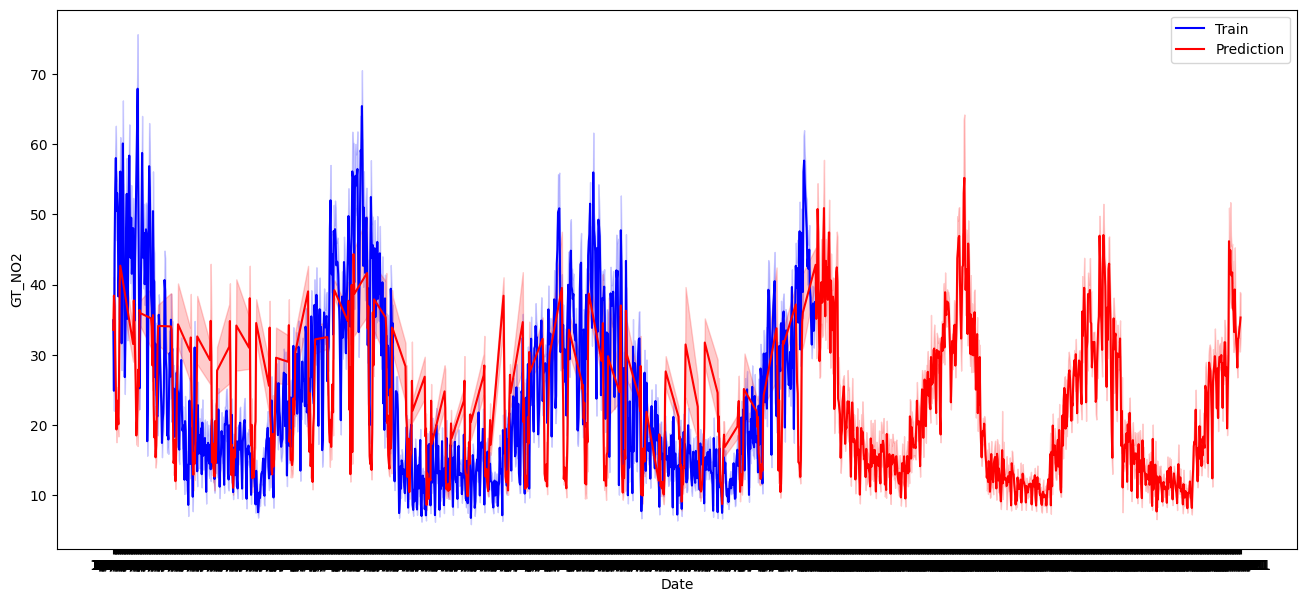

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 7))
sns.lineplot(x=train_date, y=train.GT_NO2, color='blue', label='Train')
sns.lineplot(x=test_date, y=y_pred, color='red', label='Prediction')
plt.legend()
plt.show()